### Denoising Autoencoder

From this link : https://k-d-w.org/blog/103/denoising-autoencoder-as-tensorflow-estimator

The model of Denoising Autoencoder is derived from autoencoder. Autoencoder can be splitted into two parts, the Encoding part and the Decoding part. Starting from input $X$ we apply a transformation that will encode the information into $\tilde{X}$ following a given encoding (random in our case) process. Then the objective is to find the original image starting from the encoded (noisy) input $\tilde{X}$ via a decoding process and get a good estimator $\hat{X}$ of the original data $X$.
Un auto-encodeur se compose toujours de deux parties, l'encodeur et le décodeur, qui peuvent être définies comme des transitions $\phi$ et $\psi$, telles que : 

\begin{align}
&\phi : \mathcal{X} \rightarrow \mathcal{F}\\
&\psi:\mathcal{F} \rightarrow \mathcal{X}\\
&\eta = \psi \circ \phi\\
&\eta = \arg \min_{\eta} \|X- \eta( X) \|^2
\end{align}

In the case where there is only one layer then we can summarize in the following way: take an entry $x\in \mathbb{R}^d$ (original input) and associate a transformation $\tilde{x}$ (the noisy input):

\begin{equation}
\tilde{x} = \sigma_1(W_1x + b_1)
\end{equation}

Where $\sigma$ stands for the componentwise sigmoid function for example. Then to decode the information we apply a similar process to $\tilde{x}$ to get the estimator $\hat{x}$:

\begin{equation}
\hat{x} = \sigma_2(W_2 \tilde{x} + b_2)
\end{equation}

So we are looking for minimizing the following loss function:

\begin{equation}
\mathcal{L}(x,\hat{x}) = \| x - \hat{x} \|^2
\end{equation}

### Beginning of the autoencoding construction

In [139]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 113s 2ms/step - loss: 0.2175 - val_loss: 0.1752
Epoch 2/5
60000/60000 [==============================] - 112s 2ms/step - loss: 0.1591 - val_loss: 0.1480
Epoch 3/5
60000/60000 [==============================] - 112s 2ms/step - loss: 0.1424 - val_loss: 0.1356
Epoch 4/5
60000/60000 [==============================] - 113s 2ms/step - loss: 0.1334 - val_loss: 0.1283
Epoch 5/5
60000/60000 [==============================] - 118s 2ms/step - loss: 0.1280 - val_loss: 0.1209


In [140]:
autoencoder.save("autoencoder_digit_model.hd5")

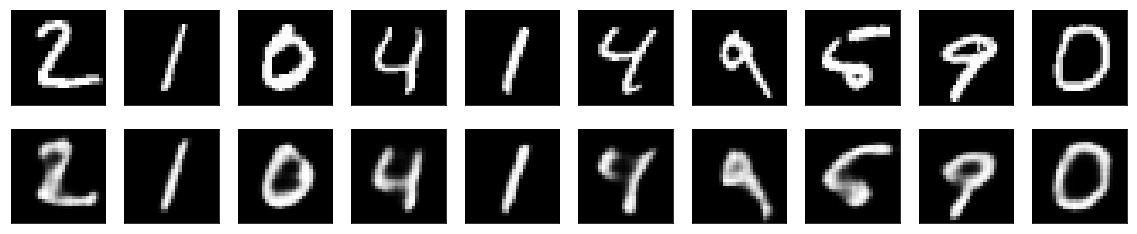

In [151]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i+1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i+1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [152]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

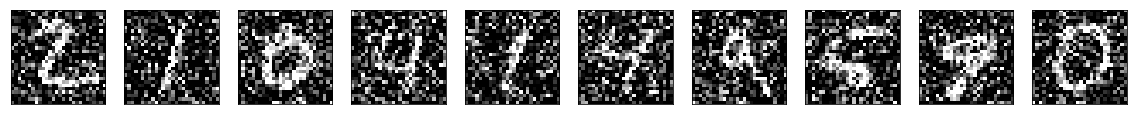

In [154]:
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i+1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [155]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [157]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 220s 4ms/step - loss: 0.1543 - val_loss: 0.1177
Epoch 2/10
60000/60000 [==============================] - 229s 4ms/step - loss: 0.1182 - val_loss: 0.1134
Epoch 3/10
60000/60000 [==============================] - 231s 4ms/step - loss: 0.1115 - val_loss: 0.1079
Epoch 4/10
60000/60000 [==============================] - 233s 4ms/step - loss: 0.1079 - val_loss: 0.1080
Epoch 5/10
60000/60000 [==============================] - 234s 4ms/step - loss: 0.1057 - val_loss: 0.1036
Epoch 6/10
60000/60000 [==============================] - 235s 4ms/step - loss: 0.1041 - val_loss: 0.1019
Epoch 7/10
60000/60000 [==============================] - 235s 4ms/step - loss: 0.1028 - val_loss: 0.1006
Epoch 8/10
60000/60000 [==============================] - 235s 4ms/step - loss: 0.1022 - val_loss: 0.1025
Epoch 9/10
60000/60000 [==============================] - 236s 4ms/step - loss: 0.1014 - val_loss: 0.1

In [158]:
autoencoder.save("autoencoder_digit_denoising_model.hd5")

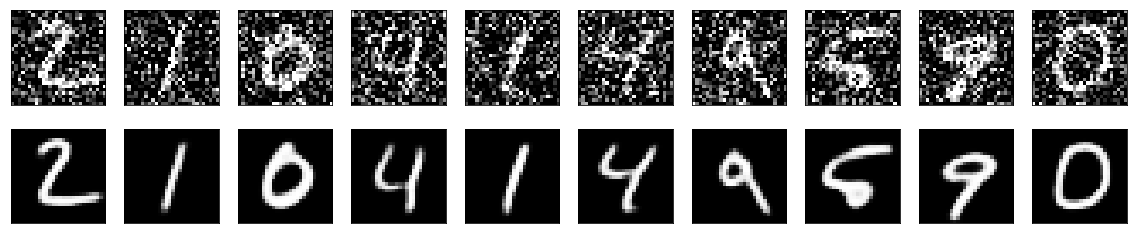

In [159]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i+1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i+1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()